# Hands-On NLP
## Class 4

<span style="color:magenta">Group Names:</span>

* Name 1
* Name 2
* Name 3

### Outline:

- Simple tokenization

- Words and indices

- Initialization

- Visualization

- Forward, cost, backward, training

- First on a sentence, then on a larger text

Main goal: understand the transformations needed to obtain vector representations

In [97]:
import doctest
import re
from collections import Counter
from datetime import datetime
from pathlib import Path
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import sklearn
from nltk.tokenize import word_tokenize
from sklearn.decomposition import PCA
from tqdm.notebook import tqdm

In [98]:
tqdm.pandas()

sns.set_style("darkgrid")
sns.set_context("notebook")

pd.set_option("display.precision", 4)

print("sklearn's version:", sklearn.__version__)    # 1.4.0
print("pandas's version:", pd.__version__)          # 2.2.0

sklearn's version: 1.6.1
pandas's version: 2.2.3


In [99]:
%config InlineBackend.figure_format="retina"  # For high DPI display

In [100]:
doctest.testmod(optionflags=doctest.ELLIPSIS)

TestResults(failed=0, attempted=6)

In [101]:
EPS = np.finfo(float).eps

TOY_CORPUS = """What is a word embedding?
A word vector (or embeddings) is a dense representation,
which captures semantic relationships between words."""

In [102]:
def tokenize(text, pattern=r"\w+"):
    """Tokenize a text into a list of tokens.
    >>> tokenize("Let's do hands-on Natural Language Processing!")
    ['let', 's', 'do', 'hands', 'on', 'natural', 'language', 'processing']
    """
    return re.findall(pattern, text.lower())

In [103]:
pprint(tokenize(TOY_CORPUS), compact=True)

['what', 'is', 'a', 'word', 'embedding', 'a', 'word', 'vector', 'or',
 'embeddings', 'is', 'a', 'dense', 'representation', 'which', 'captures',
 'semantic', 'relationships', 'between', 'words']


In [104]:
def build_vocab(tokens, show_df=False):
    """
    🚧 TODO:
    describe types of input and output of this function
    tokens: list of str
    vocab: list of str
    voc2id: dict of str:int
    end TODO
    """
    df = pd.DataFrame(Counter(tokens).most_common(), columns=["token", "count"])
    if show_df:
        display(df)

    vocab = df.token.to_list()
    voc2idx = {word: idx for idx, word in enumerate(vocab)}

    return vocab, voc2idx

### CBOW

For the calculation of the word2vec we also have the CBOW (continuous bag of words) method as an alternative to Skipgram.
In CBOW, we try to predict the central word from the whole context of the central word.
Our xs, ys training data have fewer inputs, only as many as the text has words, but are richer.
For prediction, we sum the context vectors to predict the center.

In [105]:
def generate_cbow_data(tokens, window_size):
    """
    Create the pairs xs, ys for the training:
    xs and ys have the same length (index of the central word,
    index of an observed word of the context of the central word)

    generate_cbow_data(
       ['let', 's', 'do', 'hands', 'on', 'natural', 'language', 'processing'],
       window_size=2,
    )
    ([[1, 2],
      [0, 2, 3],
      [0, 1, 3, 4],
      [1, 2, 4, 5],
      [2, 3, 5, 6],
      [3, 4, 6, 7],
      [4, 5, 7],
      [5, 6]],
     [0, 1, 2, 3, 4, 5, 6, 7])
    """
    tokens_n = len(tokens)
    _, voc2idx = build_vocab(tokens)
    xs, ys = [], []

    for i in range(tokens_n):
        # The index of the center word
        center_idx = voc2idx[tokens[i]]
        
        # Determine context bounds
        left_bound = max(0, i - window_size)
        right_bound = min(tokens_n, i + window_size + 1)
        
        # Collect the context indices (excluding the center word)
        context_indices = []
        for j in range(left_bound, right_bound):
            if j != i:
                context_indices.append(voc2idx[tokens[j]])
        
        xs.append(context_indices)
        ys.append(center_idx)

    return xs, ys

### Skipgram

In [106]:
def generate_skip_data(tokens, window_size):
    """
    create the pairs xs, ys for the training:
    xs and ys have the same length (index of the central word,
    index of an observed word of the context of the central word)

    >>> tokens = ['let', 's', 'do', 'hands', 'on', 'natural', 'language', 'processing']
    >>> xs, ys = generate_skip_data(tokens, window_size=2)
    >>> print(len(xs[0]), len(ys[0]))
    26 26
    >>> print(xs)
    [[0, 0, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 6, 6, 6, 7, 7]]
    >>> print(ys)
    [[1, 2, 0, 2, 3, 0, 1, 3, 4, 1, 2, 4, 5, 2, 3, 5, 6, 3, 4, 6, 7, 4, 5, 7, 5, 6]]
    """
    tokens_n = len(tokens)
    _, voc2idx = build_vocab(tokens)
    xs, ys = [], []

    for i in range(tokens_n):
        center_idx = voc2idx[tokens[i]]
        
        # Determine the context bounds
        left_bound = max(0, i - window_size)
        right_bound = min(tokens_n, i + window_size + 1)
        
        # For each context position j around i, add a (center, context) pair
        for j in range(left_bound, right_bound):
            if j == i:
                continue  # skip the center itself
            context_idx = voc2idx[tokens[j]]
            xs.append(center_idx)
            ys.append(context_idx)

    return [xs], [ys]

In [107]:
# let's test these functions:
tokens = tokenize(TOY_CORPUS)
pprint(tokens, compact=True)

vocab, voc2idx = build_vocab(tokens, show_df=True)

xs, ys = generate_cbow_data(tokens, 3)
print(len(xs), len(ys))
xs

['what', 'is', 'a', 'word', 'embedding', 'a', 'word', 'vector', 'or',
 'embeddings', 'is', 'a', 'dense', 'representation', 'which', 'captures',
 'semantic', 'relationships', 'between', 'words']


token  count
0                a      3
1               is      2
2             word      2
3             what      1
4        embedding      1
5           vector      1
6               or      1
7       embeddings      1
8            dense      1
9   representation      1
10           which      1
11        captures      1
12        semantic      1
13   relationships      1
14         between      1
15           words      1

20 20


[[1, 0, 2],
 [3, 0, 2, 4],
 [3, 1, 2, 4, 0],
 [3, 1, 0, 4, 0, 2],
 [1, 0, 2, 0, 2, 5],
 [0, 2, 4, 2, 5, 6],
 [2, 4, 0, 5, 6, 7],
 [4, 0, 2, 6, 7, 1],
 [0, 2, 5, 7, 1, 0],
 [2, 5, 6, 1, 0, 8],
 [5, 6, 7, 0, 8, 9],
 [6, 7, 1, 8, 9, 10],
 [7, 1, 0, 9, 10, 11],
 [1, 0, 8, 10, 11, 12],
 [0, 8, 9, 11, 12, 13],
 [8, 9, 10, 12, 13, 14],
 [9, 10, 11, 13, 14, 15],
 [10, 11, 12, 14, 15],
 [11, 12, 13, 15],
 [12, 13, 14]]

In [108]:
ys

[3, 1, 0, 2, 4, 0, 2, 5, 6, 7, 1, 0, 8, 9, 10, 11, 12, 13, 14, 15]

In [109]:
xs, ys = generate_skip_data(tokens, 3)
xs, ys = np.array(xs), np.array(ys)
print(xs.shape, ys.shape)
print(xs)

(1, 108) (1, 108)
[[ 3  3  3  1  1  1  1  0  0  0  0  0  2  2  2  2  2  2  4  4  4  4  4  4
   0  0  0  0  0  0  2  2  2  2  2  2  5  5  5  5  5  5  6  6  6  6  6  6
   7  7  7  7  7  7  1  1  1  1  1  1  0  0  0  0  0  0  8  8  8  8  8  8
   9  9  9  9  9  9 10 10 10 10 10 10 11 11 11 11 11 11 12 12 12 12 12 12
  13 13 13 13 13 14 14 14 14 15 15 15]]


In [110]:
print(ys)

[[ 1  0  2  3  0  2  4  3  1  2  4  0  3  1  0  4  0  2  1  0  2  0  2  5
   0  2  4  2  5  6  2  4  0  5  6  7  4  0  2  6  7  1  0  2  5  7  1  0
   2  5  6  1  0  8  5  6  7  0  8  9  6  7  1  8  9 10  7  1  0  9 10 11
   1  0  8 10 11 12  0  8  9 11 12 13  8  9 10 12 13 14  9 10 11 13 14 15
  10 11 12 14 15 11 12 13 15 12 13 14]]


In [111]:
vocab, voc2idx = build_vocab(tokens)
vocab_size = len(vocab)
ys = np.array(ys)
m = np.array(ys).shape[1]

# ys in one-hot encoding:
one_hot_ys = np.zeros((vocab_size, m))
one_hot_ys[ys.flatten(), np.arange(m)] = 1  # important to understand for later!
one_hot_ys.shape  # can you explain the shape?

(16, 108)

### 🚧 TODO:

*   Explain why there are three 3's, four 1's... in `xs`

xs (center indices): For each position i in the list of tokens, the center token index is repeated once for every context neighbor. That’s why wee see each index multiple times in groups (3, 4, or 6 repeats, etc.), depending on boundary conditions.

*   Explain why there are more 0's than, e.g., 3's in `ys`

ys (context indices): Tokens that appear more frequently in the text or end up within window-size distance of many center tokens will appear more often as context tokens. Hence a heavily repeated token (index 0 in the example) can appear many more times than another token (index 3) in ys.

In [112]:
def initialize_embeddings(vocab_size, emb_size, seed=None):
    """
    vocab_size (int): vocabulary size of your corpus or training data
    emb_size (int): word embedding size (dimensions to represent each word)
    returns a matrix of size (vocab_size, emb_size)
    🚧 TODO: complete the "_____"
    returns a matrix of shape: (vocab_size, emb_size)
    each row corresponds to the word embedding of a word in the vocabulary
    end TODO
    """
    rng = np.random.default_rng(seed)
    return rng.normal(loc=0, scale=0.01, size=(vocab_size, emb_size))

Check out the parameters in the doc: [np.random.Generator.normal](https://numpy.org/doc/stable/reference/random/generated/numpy.random.Generator.normal.html#numpy.random.Generator.normal).

In [113]:
def initialize_dense(input_size, output_size, seed=None):
    """
    input_size (int): size of the input to the dense layer
    output_size (int): size of the output of the dense layer
    🚧 TODO: complete the "______"
    returns a matrix of shape : (output_size, input_size)
    each row corresponds to the values of a parameter in the dense layer
    end TODO
    """
    rng = np.random.default_rng(seed)
    return rng.normal(loc=0, scale=0.01, size=(output_size, input_size))

In [114]:
def initialize_parameters(vocab_size, emb_size, seed=None):
    """
    Initialize all the training parameters
    """
    embs = initialize_embeddings(vocab_size, emb_size, seed)
    ws = initialize_dense(emb_size, vocab_size, seed)

    parameters = {}
    parameters["EMBS"] = embs
    parameters["W"] = ws

    return parameters

In [115]:
# for example an embedding of dimension 5
parameters = initialize_parameters(len(vocab), emb_size=5, seed=42)

In [116]:
print(parameters["EMBS"].shape, parameters["W"].shape)

(16, 5) (16, 5)


In [117]:
# We can multiply them:
(parameters["EMBS"].T @ parameters["W"]).shape

(5, 5)

In [118]:
def plot_embedding(vs, indices, vocab):
    pca = PCA(n_components=2)
    data = pca.fit_transform(vs).transpose()
    xs, ys = data[0], data[1]
    fig, ax = plt.subplots(figsize=(15, 8))
    ax.scatter(xs, ys, c="green")
    for i, idx in enumerate(indices):
        ax.annotate(
            vocab[idx], (xs[i], ys[i]), xytext=(5, 5), textcoords="offset points"
        )
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("2 dimensions of the word embeddings")
    plt.show()

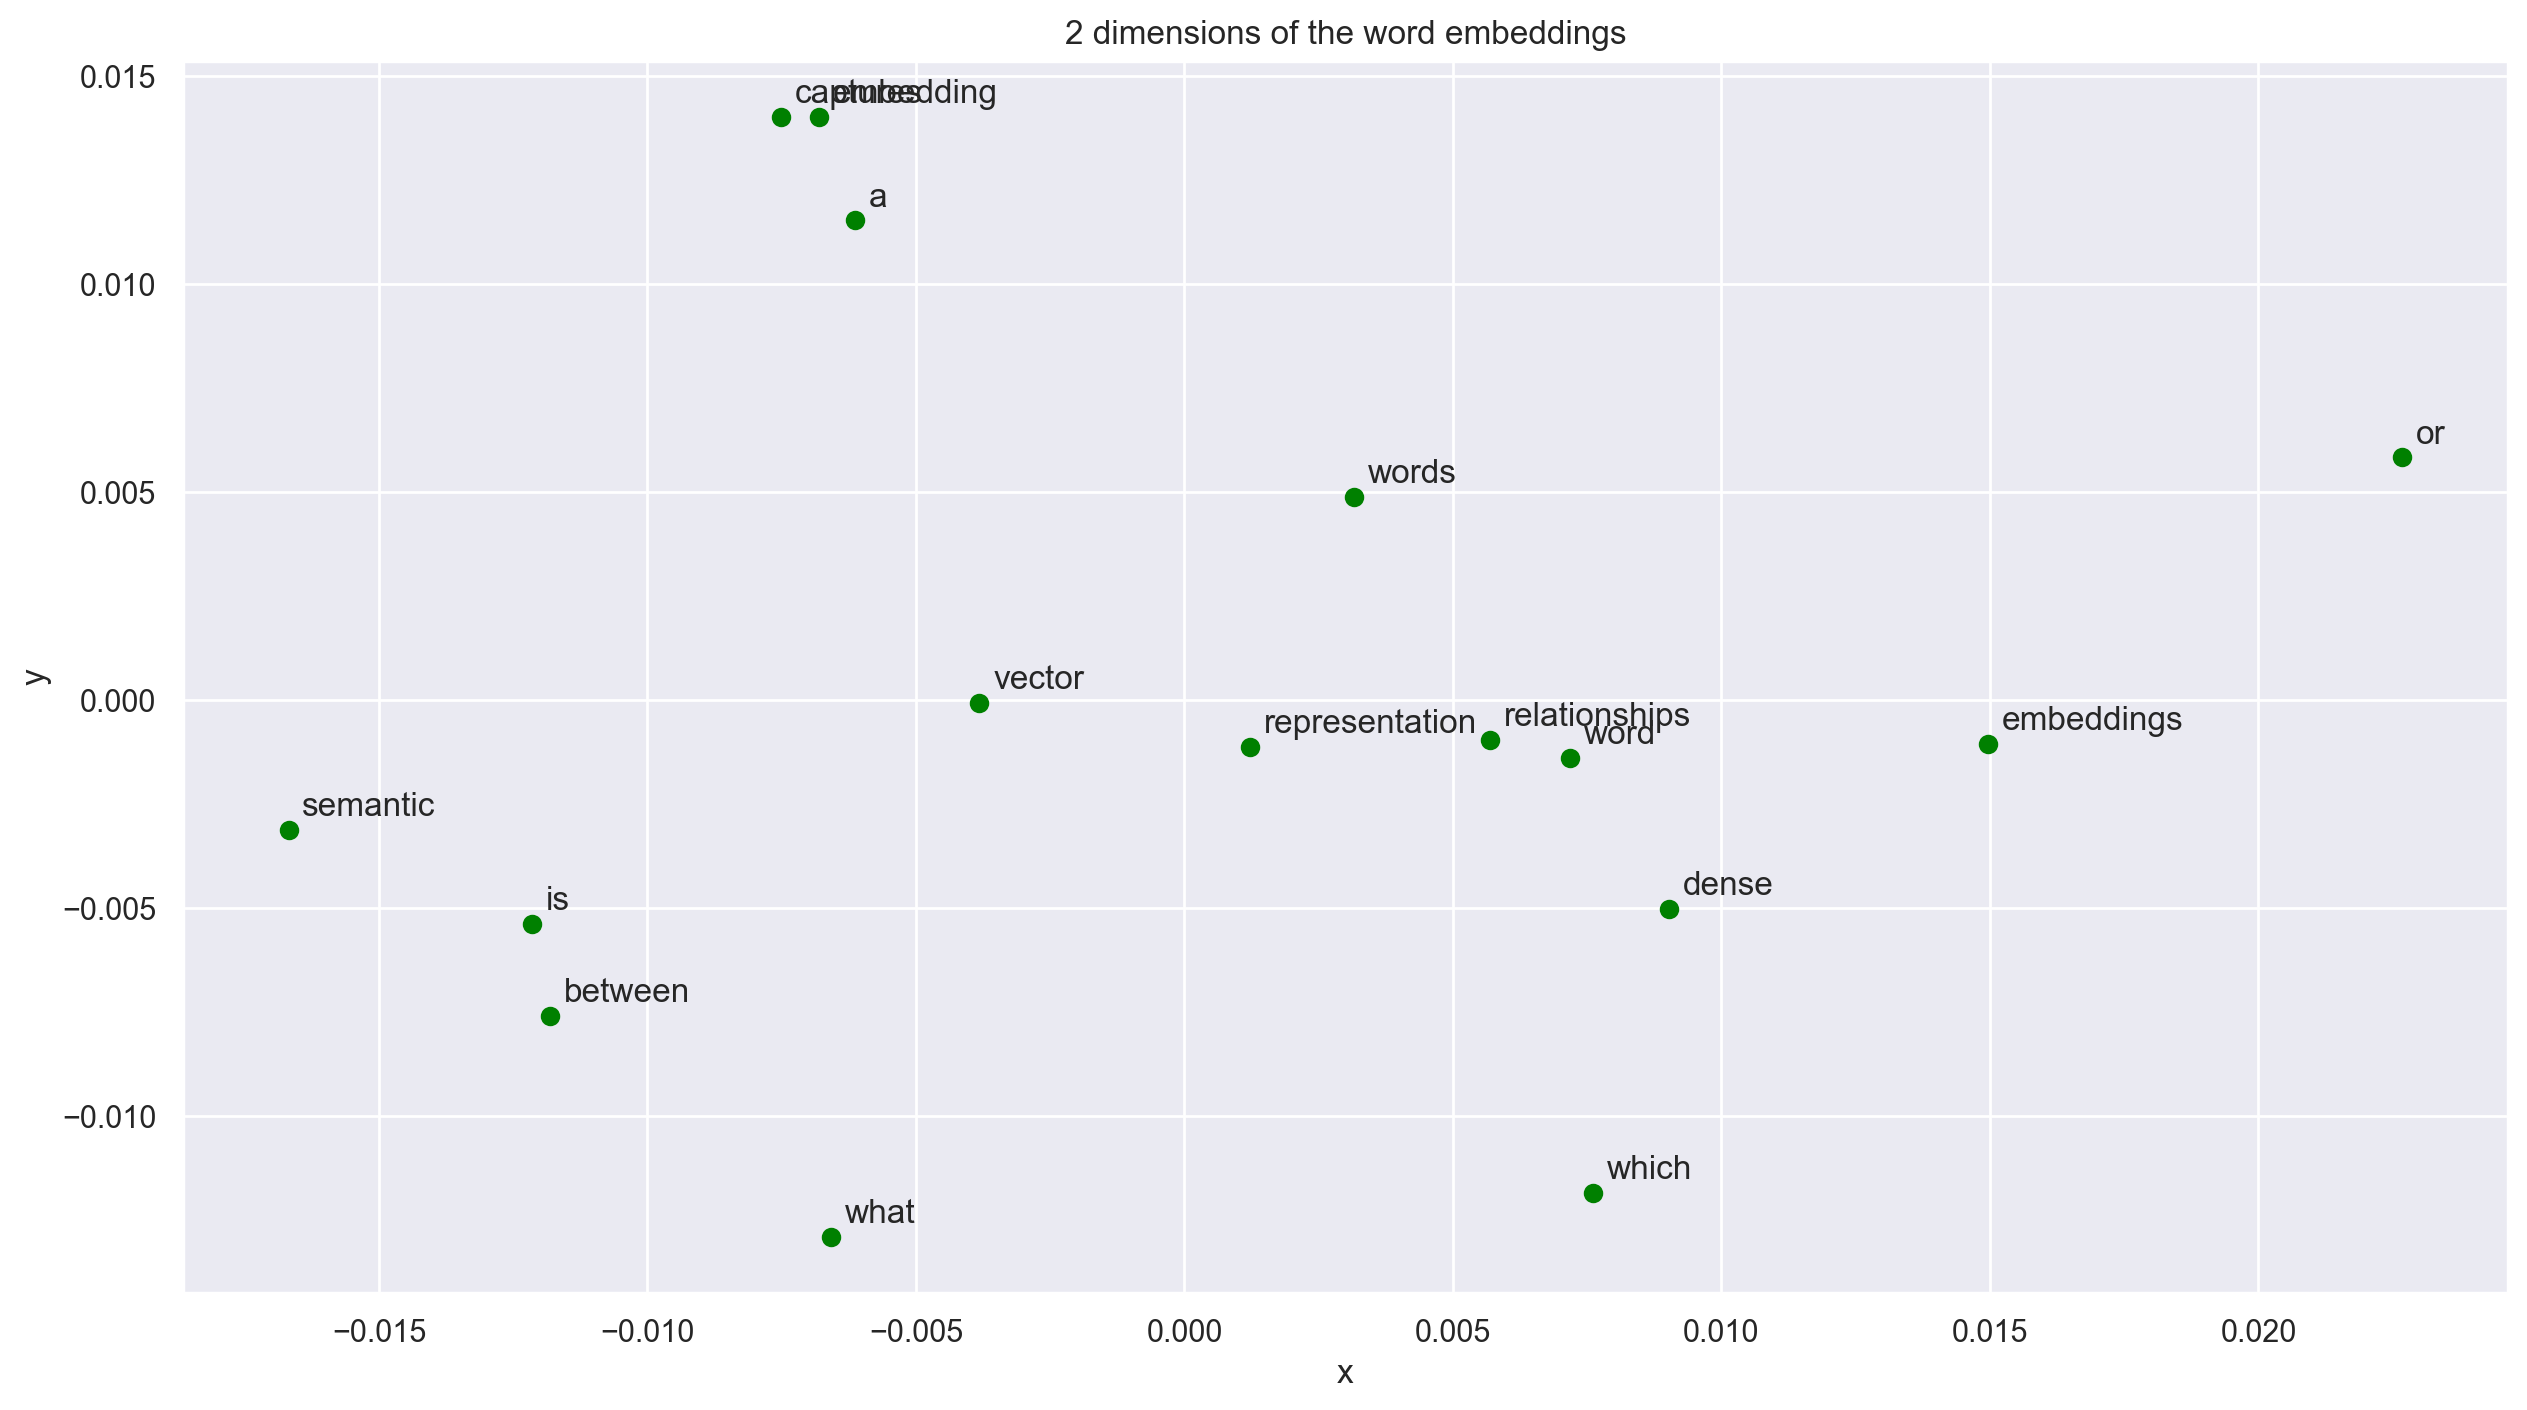

In [119]:
# plotting all the words that have just been initialized:
# print(parameters["emb"].shape)
plot_embedding(parameters["EMBS"], voc2idx.values(), vocab)

In [120]:
def ind_to_word_embs(inds, parameters):
    """
    inds: numpy array. shape: (1, m)
    parameters: dict. weights to be trained

    🚧 TODO: complete:
    returns a matrix of word vectors as columns with shape (embs.shape[1], m)
    end TODO

    """
    m = inds.shape[1]
    embs = parameters["EMBS"]

    # Select the rows of the embedding matrix corresponding to the indices
    #     flatten() -> 1D array (as many elements as indices)
    w_embs = embs[inds.flatten(), :].T

    assert w_embs.shape == (embs.shape[1], m)

    return w_embs

In [121]:
def linear_dense(w_embs, parameters):
    """
    w_embs: numpy array. shape: (emb_size, m)
    parameters: dict. weights to be trained
    returns: ws et zs
    ws: matrix of weights of the dense layer
    zs: output matrix of the dense layer
        🚧 TODO: complete :
        zs is of shape: (ws.shape[0], m)

    """
    m = w_embs.shape[1]
    ws = parameters["W"]
    zs = np.dot(ws, w_embs)

    assert zs.shape == (ws.shape[0], m)

    return ws, zs

In [122]:
def softmax(zs):
    """
    zs: output out of the dense layer.
        shape: (vocab_size, m = number of input vectors (tokens to update))
    """
    softmax_out = np.divide(
        np.exp(zs), np.sum(np.exp(zs), axis=0, keepdims=True) + EPS
    )
    assert softmax_out.shape == zs.shape

    return softmax_out

In [123]:
def forward_propagation(inds, parameters):
    w_embs = ind_to_word_embs(inds, parameters)
    ws, zs = linear_dense(w_embs, parameters)
    softmax_out = softmax(zs)

    caches = {}
    caches["inds"] = inds
    caches["w_embs"] = w_embs
    caches["W"] = ws
    caches["Z"] = zs
    return softmax_out, caches

In [124]:
def cross_entropy(softmax_out, ys):
    """
    softmax_out: output out of softmax. shape: (vocab_size, m=batch_size)
    ys: ground truth: indices à prédire. shape: (1, m)
    """
    m = softmax_out.shape[1]

    cost = -(1 / m) * np.sum(
        np.log(softmax_out[ys.flatten(), np.arange(ys.shape[1])] + EPS)
    )
    return cost

🚧 TODO, read this carrefully:

* From the softmax out, I select the lines corresponding to the predicted tokens

* It gives me the probabilities, I take the log, and I average it

* If the prediction was perfect, the probability would be 1, the log is 0 --> zero cost

* If not, I have a proba smaller than 1, I take the average of these probas logs (which are all negative)

* With the "$-$" it becomes positive, so it is a measure of the error of the prediction

* Note that `ys` can contain several times the same index to predict. It is counted as many times as it should be predicted.

$$\frac{dL}{dZ} = softmax\_out - ys$$

$$\frac{dL}{dW} = \frac{dL}{dZ}\times\frac{dZ}{dW}= \frac{dL}{dZ}\times w\_embs.T$$

$$
\frac{dL}{d w\_embs} = \frac{dL}{dZ}\times\frac{dZ}{d w\_embs}
    = \frac{dL}{dZ} \times W.T
$$

In [125]:
def softmax_backward(ys, softmax_out):
    """
    ys: labels of training data. shape: (1, m=batch_size)
    softmax_out: output out of softmax. shape: (vocab_size, m=batch_size)
    """
    m = ys.shape[1]

    # we compute the difference between the prediction and the ground truth (ys)
    # if the prediction was perfect, the dl_dz becomes 0
    # we only touch the lines to predict
    # if the token is not to be predicted, we do not touch the line
    softmax_out[ys.flatten(), np.arange(m)] -= 1.0
    dl_dz = softmax_out

    assert dl_dz.shape == softmax_out.shape
    return dl_dz

In [126]:
def dense_backward(dl_dz, caches):
    """
    dl_dz: shape: (vocab_size, m)
    caches: dict. results from each steps of forward propagation
    dl_dz has negative values where something needs to be changed.
    the more negative they are, the worse it is.
    """
    ws = caches["W"]
    w_embs = caches["w_embs"]
    m = w_embs.shape[1]

    # we multiply where we need to change something:
    # dl_dz.shape = (vocab_size, m)
    dl_dw = (1 / m) * np.dot(dl_dz, w_embs.T)
    dl_dw_embs = np.dot(ws.T, dl_dz)

    assert ws.shape == dl_dw.shape
    assert w_embs.shape == dl_dw_embs.shape

    return dl_dw, dl_dw_embs

In [127]:
def backward_propagation(ys, softmax_out, caches):
    dl_dz = softmax_backward(ys, softmax_out)
    dl_dw, dl_dw_embs = dense_backward(dl_dz, caches)

    gradients = dict()
    gradients["dL_dZ"] = dl_dz
    gradients["dL_dW"] = dl_dw
    gradients["dL_dw_embs"] = dl_dw_embs

    return gradients

In [128]:
def update_parameters(parameters, caches, gradients, learning_rate):
    """
    here we update the embedding
    """
    vocab_size, emb_size = parameters["EMBS"].shape
    inds = caches["inds"]
    embs = parameters["EMBS"]
    dl_dw_embs = gradients["dL_dw_embs"]
    m = inds.shape[-1]

    # note that only the lines corresponding to the central words are modified
    embs[inds.flatten(), :] -= dl_dw_embs.T * learning_rate

    parameters["W"] -= learning_rate * gradients["dL_dW"]

In [129]:
def skipgram_model_training(
    xs,
    ys,
    vocab_size,
    emb_size,
    learning_rate,
    epochs,
    batch_size=256,
    parameters=None,
    print_cost=False,
    plot_cost=True,
):
    costs = []
    m = xs.shape[1]

    if parameters is None:
        parameters = initialize_parameters(vocab_size, emb_size)

    # for the moment these three variables are not used
    # 🚧 TODO: use these variables to keep the best model at the end
    best_epoch = 0
    min_epoch_cost = float("inf")
    parameters["best_embeddings"] = parameters["EMBS"]

    begin_time = datetime.now()
    for epoch in range(epochs):
        epoch_cost = 0
        batch_inds = list(range(0, m, batch_size))
        np.random.shuffle(batch_inds)
        for i in batch_inds:
            batch_xs = xs[:, i : i + batch_size]
            batch_ys = ys[:, i : i + batch_size]

            softmax_out, caches = forward_propagation(batch_xs, parameters)
            cost = cross_entropy(softmax_out, batch_ys)
            gradients = backward_propagation(batch_ys, softmax_out, caches)
            update_parameters(parameters, caches, gradients, learning_rate)
            epoch_cost += cost

        costs.append(epoch_cost)
        if epoch_cost < min_epoch_cost:
            best_epoch = epoch
            min_epoch_cost = epoch_cost
            parameters["best_embeddings"] = np.copy(parameters["EMBS"])

        if print_cost and epoch % 200 == 0:
            print(f"Cost after epoch {epoch:4d}: {epoch_cost:.4f}")
        if epoch % (epochs // 100) == 0:
            learning_rate *= 0.98
    end_time = datetime.now()
    print(f"training time: {end_time - begin_time}")
    print(
        f"🚧 TODO I've kept the embedding of epoch {best_epoch} "
        f"with cost {min_epoch_cost:.4f}."
    )
    if plot_cost:
        plt.plot(np.arange(epochs), costs)
        plt.xlabel("# of epochs")
        plt.ylabel("cost")
    return parameters

In [130]:
print(ys.shape, xs.shape, one_hot_ys.shape)

(1, 108) (1, 108) (16, 108)


Cost after epoch    0: 2.7726
Cost after epoch  200: 2.7488
Cost after epoch  400: 2.5633
Cost after epoch  600: 2.4354
Cost after epoch  800: 2.3254
Cost after epoch 1000: 2.2716
Cost after epoch 1200: 2.2464
Cost after epoch 1400: 2.2332
Cost after epoch 1600: 2.2255
Cost after epoch 1800: 2.2204
Cost after epoch 2000: 2.2166
Cost after epoch 2200: 2.2137
Cost after epoch 2400: 2.2116
Cost after epoch 2600: 2.2103
Cost after epoch 2800: 2.2096
training time: 0:00:00.371014
🚧 TODO I've kept the embedding of epoch 2985 with cost 2.2094.


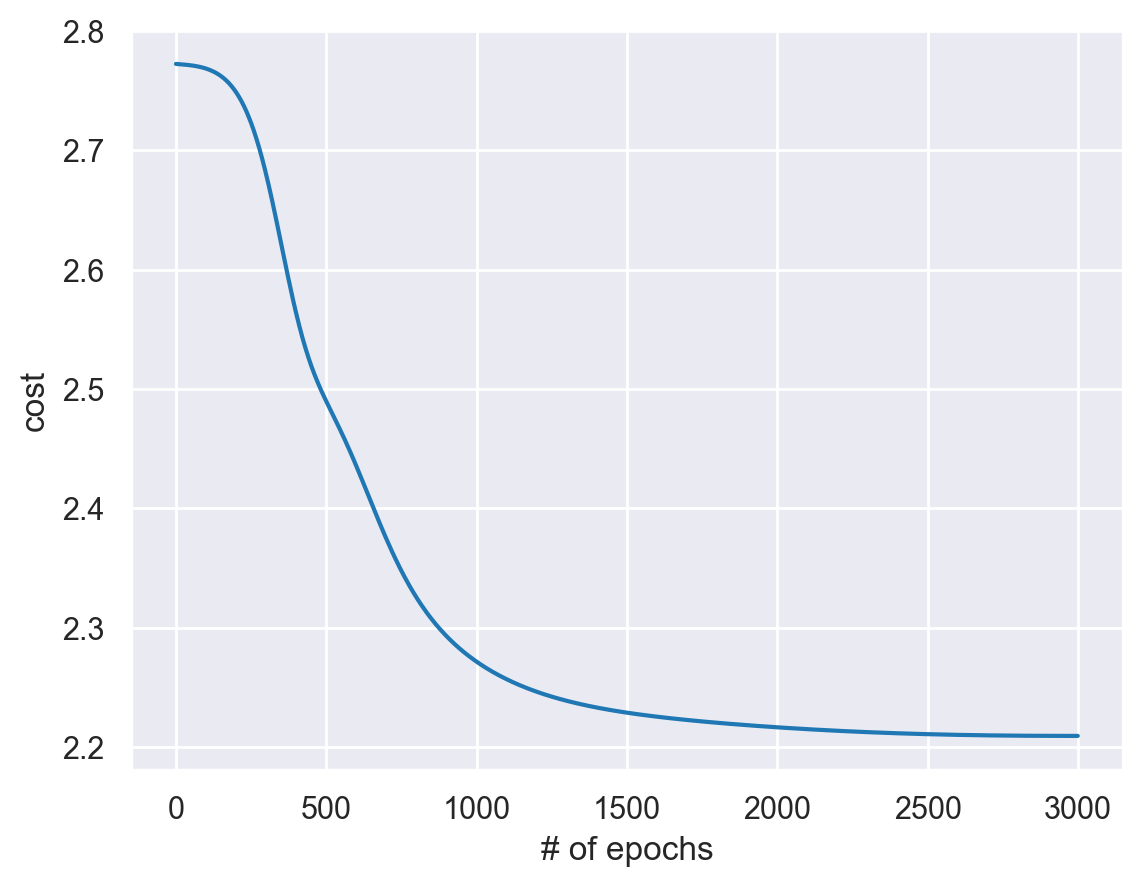

In [131]:
parameters = skipgram_model_training(
    xs,
    ys,
    vocab_size,
    emb_size=50,
    learning_rate=0.05,
    epochs=3000,
    batch_size=128,
    parameters=None,
    print_cost=True,
)
# test with a small batch_size to see....

####  🚧 TODO:

- Keep the best model

- Visualize also the best model

In [132]:
best_embeddings = parameters["best_embeddings"]
np.save("best_skipgram_embeddings.npy", best_embeddings)

print("Best embeddings saved to best_skipgram_embeddings.npy")

Best embeddings saved to best_skipgram_embeddings.npy


### First intrinsic evaluation

- Let's take the indices of all the words

- Send them into the grinder

- See if the system can predict the words that were close as the most probable

In [133]:
test_xs = np.arange(vocab_size)
print(test_xs, test_xs.shape)
test_xs = np.expand_dims(test_xs, axis=0)
print(test_xs, test_xs.shape)

# send test_xs to the forward_propagation
softmax_test, _ = forward_propagation(test_xs, parameters)

# find the 5 most likely indices:
top_sorted_inds = np.argsort(softmax_test, axis=0)[-5:, :]

top_sorted_inds

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] (16,)
[[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]] (1, 16)


array([[ 2,  7,  5,  5, 14,  4,  7,  0,  7,  1, 11, 10, 13, 13, 13, 10],
       [ 4,  3,  2,  7,  1,  2,  5,  1,  9, 10,  8,  8, 10, 10, 10,  8],
       [ 1,  8,  0,  0,  0,  0,  1,  6,  0, 11,  9, 13, 14, 14, 14, 13],
       [ 9,  0,  4,  1,  5,  7,  2,  5, 10,  8, 13, 14, 11, 11, 11, 14],
       [10,  9,  7,  2,  2,  1,  0,  8, 11, 12, 12, 12, 15, 15, 15, 12]])

In [134]:
for input_ind in range(vocab_size):
    input_word = vocab[input_ind]
    output_words = [
        vocab[output_ind] for output_ind in top_sorted_inds[::-1, input_ind]
    ]  # explain ::-1 in few words
    print(f"{input_word}'s neighbor words: {output_words}")

a's neighbor words: ['which', 'representation', 'is', 'embedding', 'word']
is's neighbor words: ['representation', 'a', 'dense', 'what', 'embeddings']
word's neighbor words: ['embeddings', 'embedding', 'a', 'word', 'vector']
what's neighbor words: ['word', 'is', 'a', 'embeddings', 'vector']
embedding's neighbor words: ['word', 'vector', 'a', 'is', 'between']
vector's neighbor words: ['is', 'embeddings', 'a', 'word', 'embedding']
or's neighbor words: ['a', 'word', 'is', 'vector', 'embeddings']
embeddings's neighbor words: ['dense', 'vector', 'or', 'is', 'a']
dense's neighbor words: ['captures', 'which', 'a', 'representation', 'embeddings']
representation's neighbor words: ['semantic', 'dense', 'captures', 'which', 'is']
which's neighbor words: ['semantic', 'relationships', 'representation', 'dense', 'captures']
captures's neighbor words: ['semantic', 'between', 'relationships', 'dense', 'which']
semantic's neighbor words: ['words', 'captures', 'between', 'which', 'relationships']
relati

[::-1] reverses the first dimension (rows) of top_sorted_inds. This means that instead of accessing the top-ranked indices in their original order, they are accessed in reverse order. Essentially, it flips the ranking direction before selecting output_ind values for each input_ind.

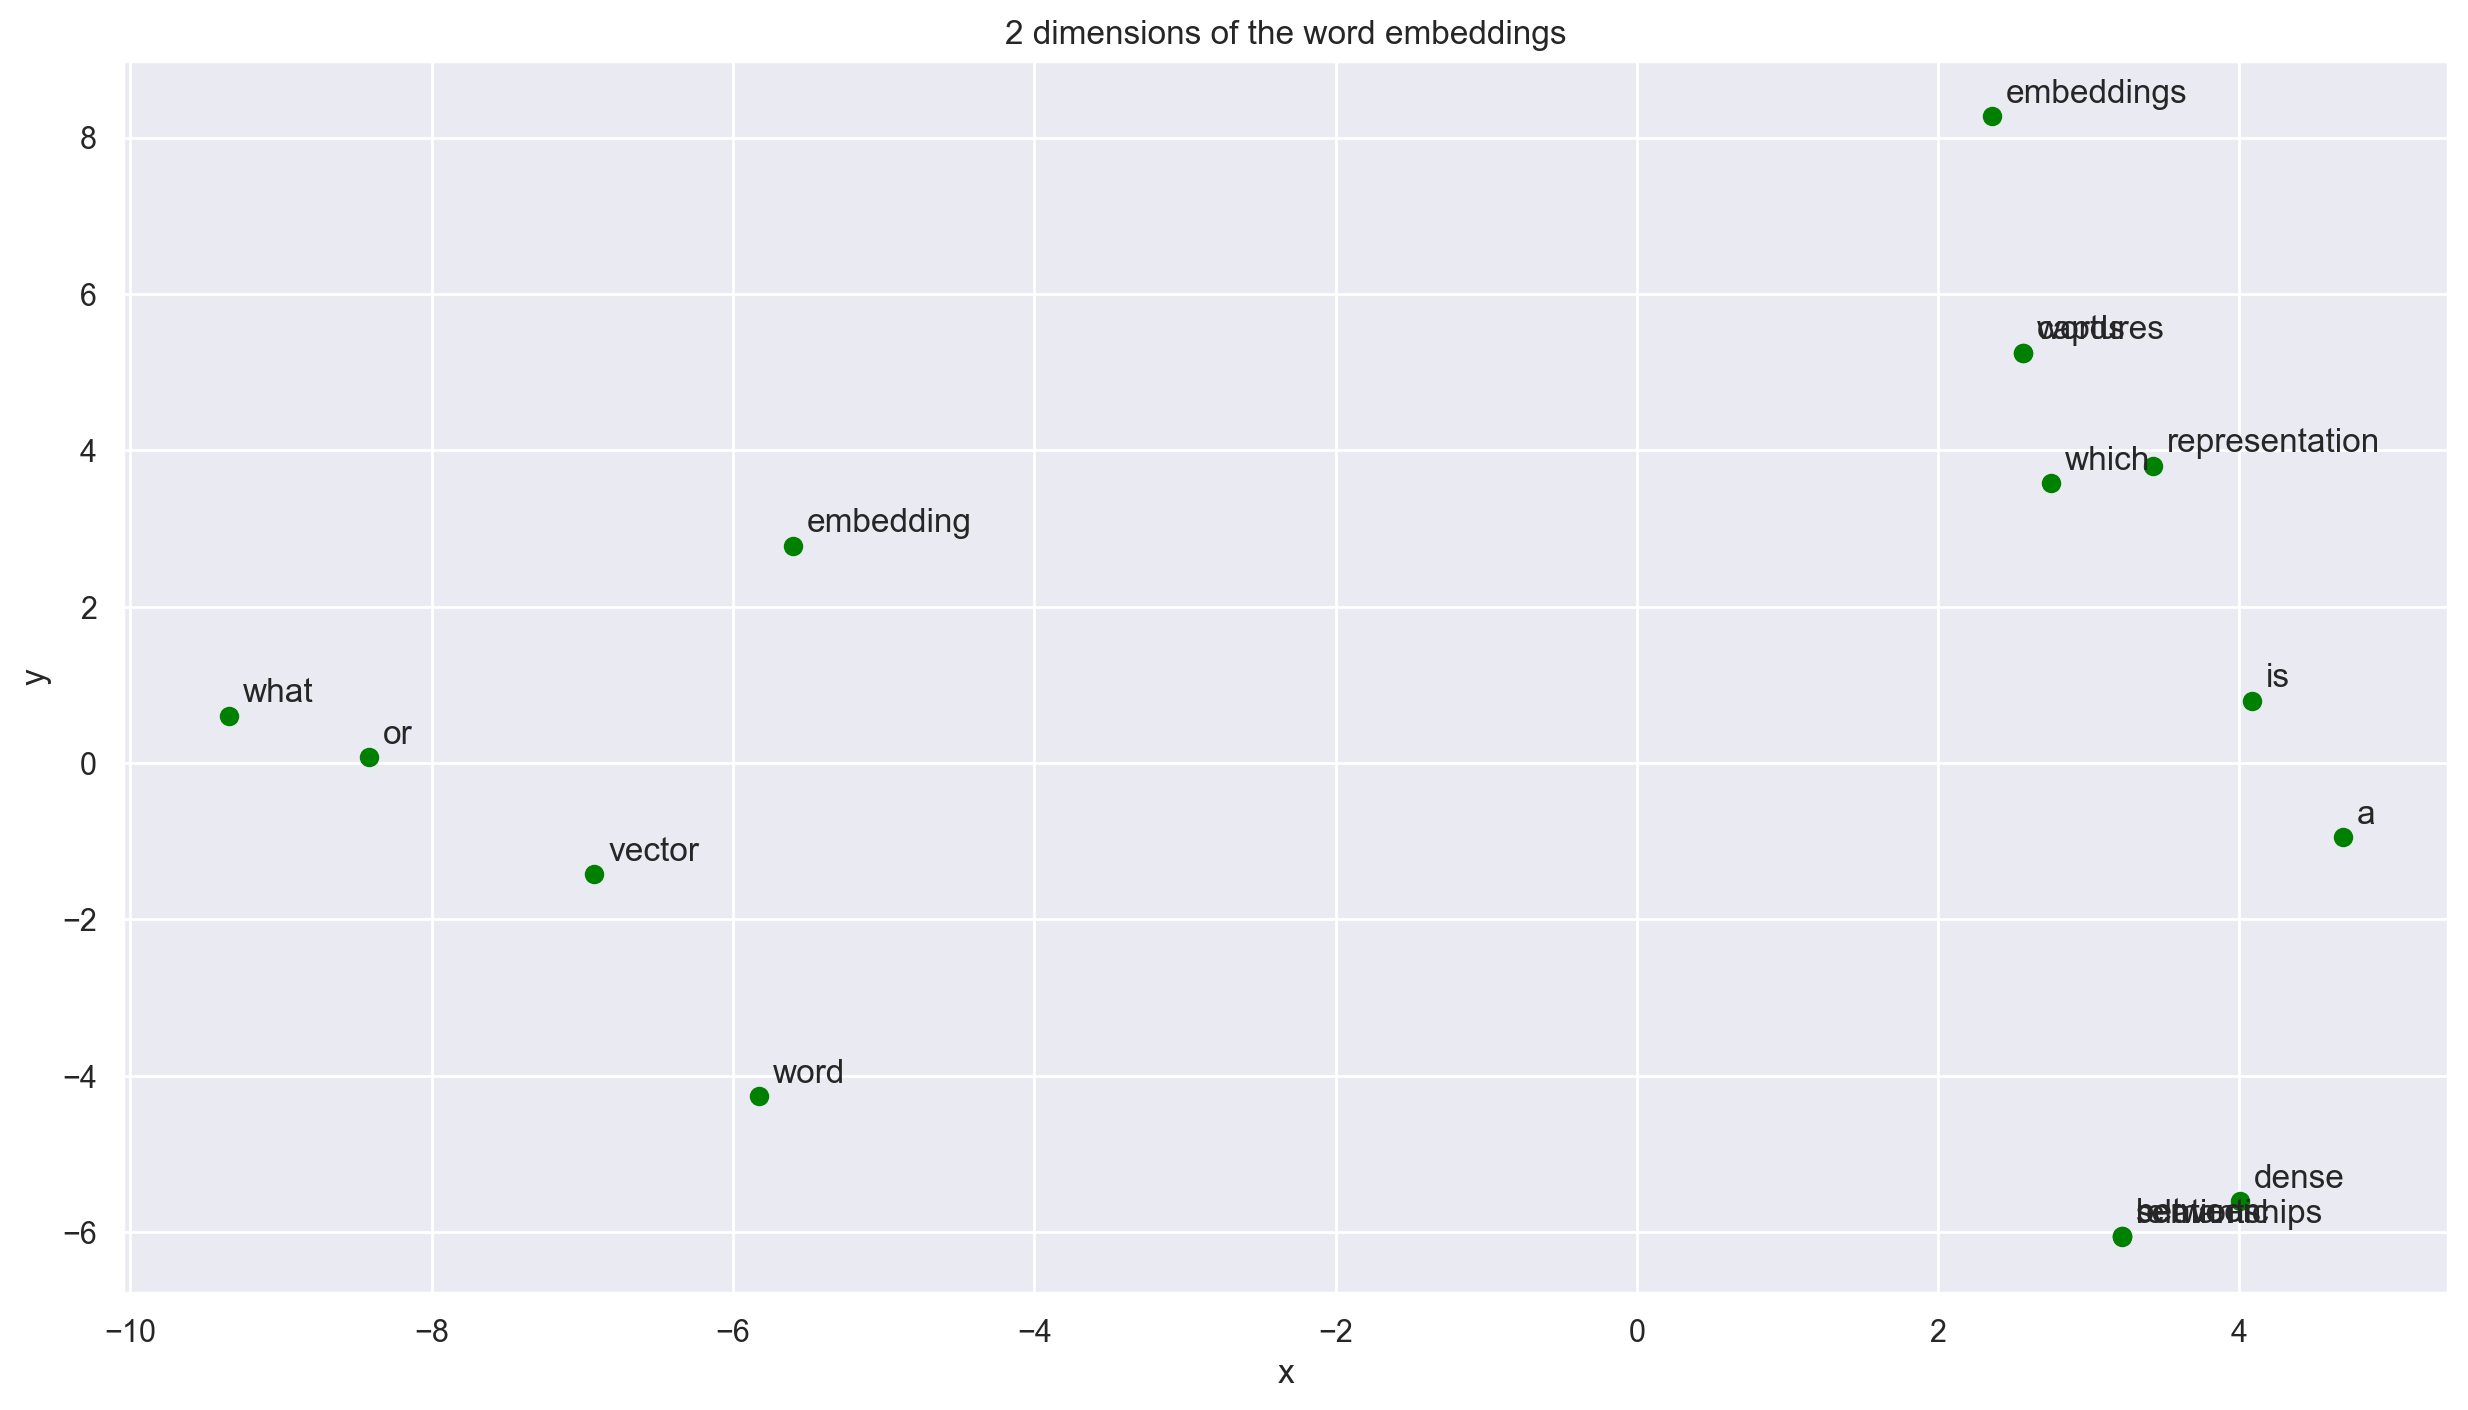

In [135]:
plot_embedding(parameters["best_embeddings"], test_xs[0], vocab)

In [136]:
parameters["best_embeddings"].shape

(16, 50)

In [137]:
# Let's calculate the cosine distance between all words

cos_dists = scipy.spatial.distance.cdist(
    parameters["best_embeddings"], parameters["best_embeddings"], "cosine"
)
cos_dists.shape
vocab

['a',
 'is',
 'word',
 'what',
 'embedding',
 'vector',
 'or',
 'embeddings',
 'dense',
 'representation',
 'which',
 'captures',
 'semantic',
 'relationships',
 'between',
 'words']

In [138]:
def costs_heatmap(costs, vocab):
    plt.figure(figsize=(9, 8))
    sns.heatmap(
        costs,
        annot=costs.round(1),
        xticklabels=vocab,
        yticklabels=vocab,
        cmap="RdPu",
    )

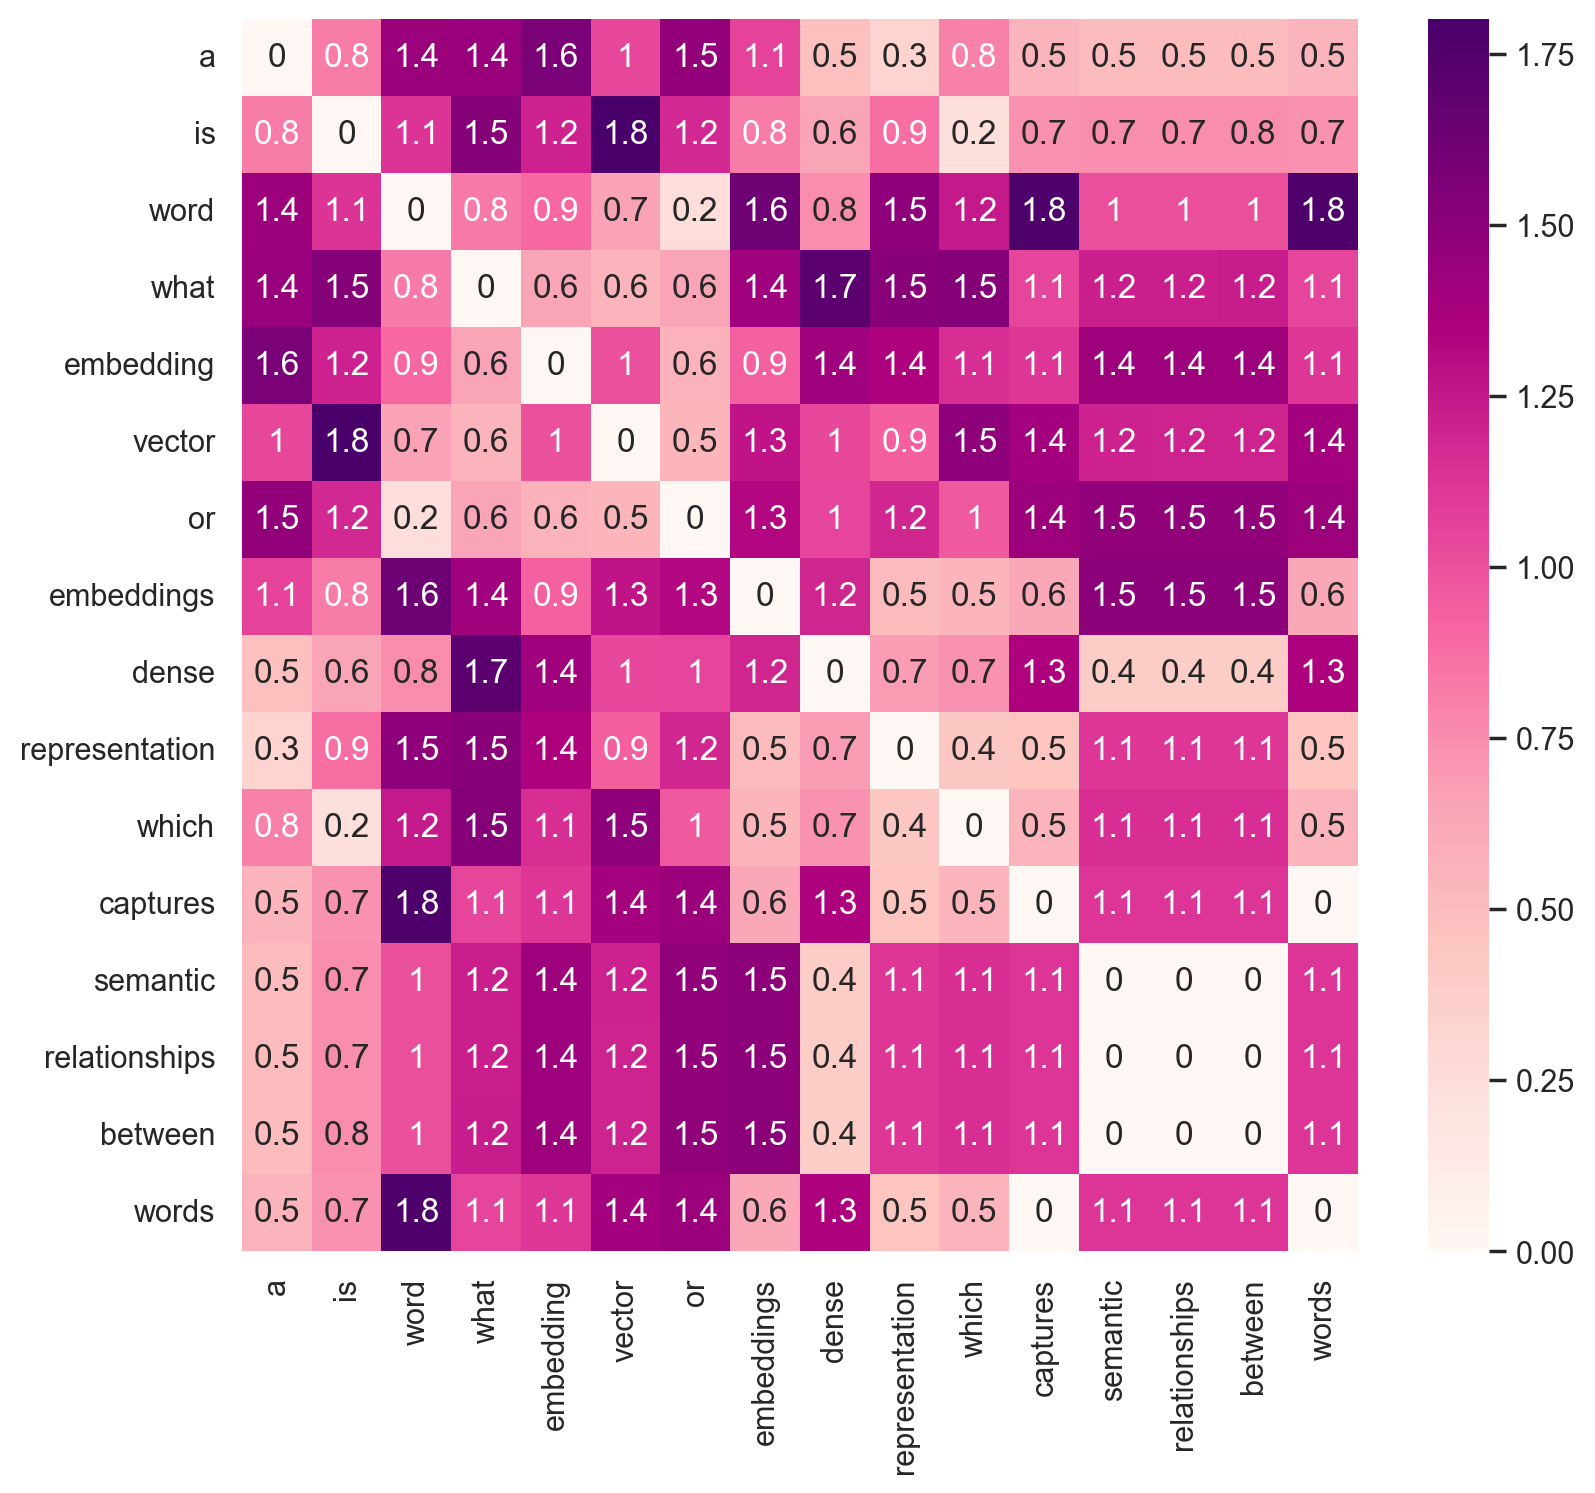

In [139]:
costs_heatmap(cos_dists, vocab)

In [140]:
### 🚧 attempt a short hande-waving explanations of what you see in the heatmap

The diagonal is all zeros because each word is compared to itself, meaning perfect similarity.

Some words (e.g., "word," "embedding," "vector") show high similarity to each other, likely because they are conceptually related in the context.

Less related words (e.g., "a" and "relationships") tend to have lower similarity scores.

Blocks of high similarity suggest clusters of words that share semantic meaning, such as "semantic," "relationships," and "between."

## A longer text

In [141]:
text = """The celestial sphere is an imaginary projection of the Sun, Moon,
planets, stars, and all astronomical bodies upon an imaginary sphere surrounding
Earth. Although originally developed as part of the ancient Greek concept of an
Earth-centered (geocentric) universe, the hypothetical celestial sphere gives
astronomers an important tool for fixing the location and plotting movements of
celestial objects. Ancient Greek astronomers envisioned concentric crystalline
spheres centered around Earth, upon which the Sun, Moon, planets, and stars
moved. Although heliocentric (Sun-centered) models of the universe were also
proposed by the Greeks, they were disregarded as counterintuitive to the
apparent motions of celestial bodies across the sky. Corresponding to Earth’s
rotation, the celestial sphere rotates through 1° in about four minutes. Because
of this, sunrise, sunset, moonrise, and moon-set, all take approximately two
minutes because both the Sun and Moon have the same apparent size on the
celestial sphere (about 0.5°). The Sun is, of course, much larger, but the Moon
is much closer. """

### Do the same thing again

for this larger text

In [142]:
tokens = tokenize(text)
print(Counter(tokens))

vocab, voc2idx = build_vocab(tokens, show_df=True)
xs, ys = generate_skip_data(tokens, 3)

xs, ys = np.array(xs), np.array(ys)
vocab_size = len(vocab)

m = ys.shape[1]
print("m:", m)

Counter({'the': 16, 'of': 8, 'celestial': 6, 'sphere': 5, 'sun': 5, 'moon': 5, 'and': 5, 'an': 4, 'earth': 4, 'is': 3, 'centered': 3, 'imaginary': 2, 'planets': 2, 'stars': 2, 'all': 2, 'bodies': 2, 'upon': 2, 'although': 2, 'as': 2, 'ancient': 2, 'greek': 2, 'universe': 2, 'astronomers': 2, 'were': 2, 'to': 2, 'apparent': 2, 'about': 2, 'minutes': 2, 'because': 2, 'much': 2, 'projection': 1, 'astronomical': 1, 'surrounding': 1, 'originally': 1, 'developed': 1, 'part': 1, 'concept': 1, 'geocentric': 1, 'hypothetical': 1, 'gives': 1, 'important': 1, 'tool': 1, 'for': 1, 'fixing': 1, 'location': 1, 'plotting': 1, 'movements': 1, 'objects': 1, 'envisioned': 1, 'concentric': 1, 'crystalline': 1, 'spheres': 1, 'around': 1, 'which': 1, 'moved': 1, 'heliocentric': 1, 'models': 1, 'also': 1, 'proposed': 1, 'by': 1, 'greeks': 1, 'they': 1, 'disregarded': 1, 'counterintuitive': 1, 'motions': 1, 'across': 1, 'sky': 1, 'corresponding': 1, 's': 1, 'rotation': 1, 'rotates': 1, 'through': 1, '1': 1, 

token  count
0         the     16
1          of      8
2   celestial      6
3      sphere      5
4         sun      5
..        ...    ...
89          5      1
90     course      1
91     larger      1
92        but      1
93     closer      1

[94 rows x 2 columns]

m: 984


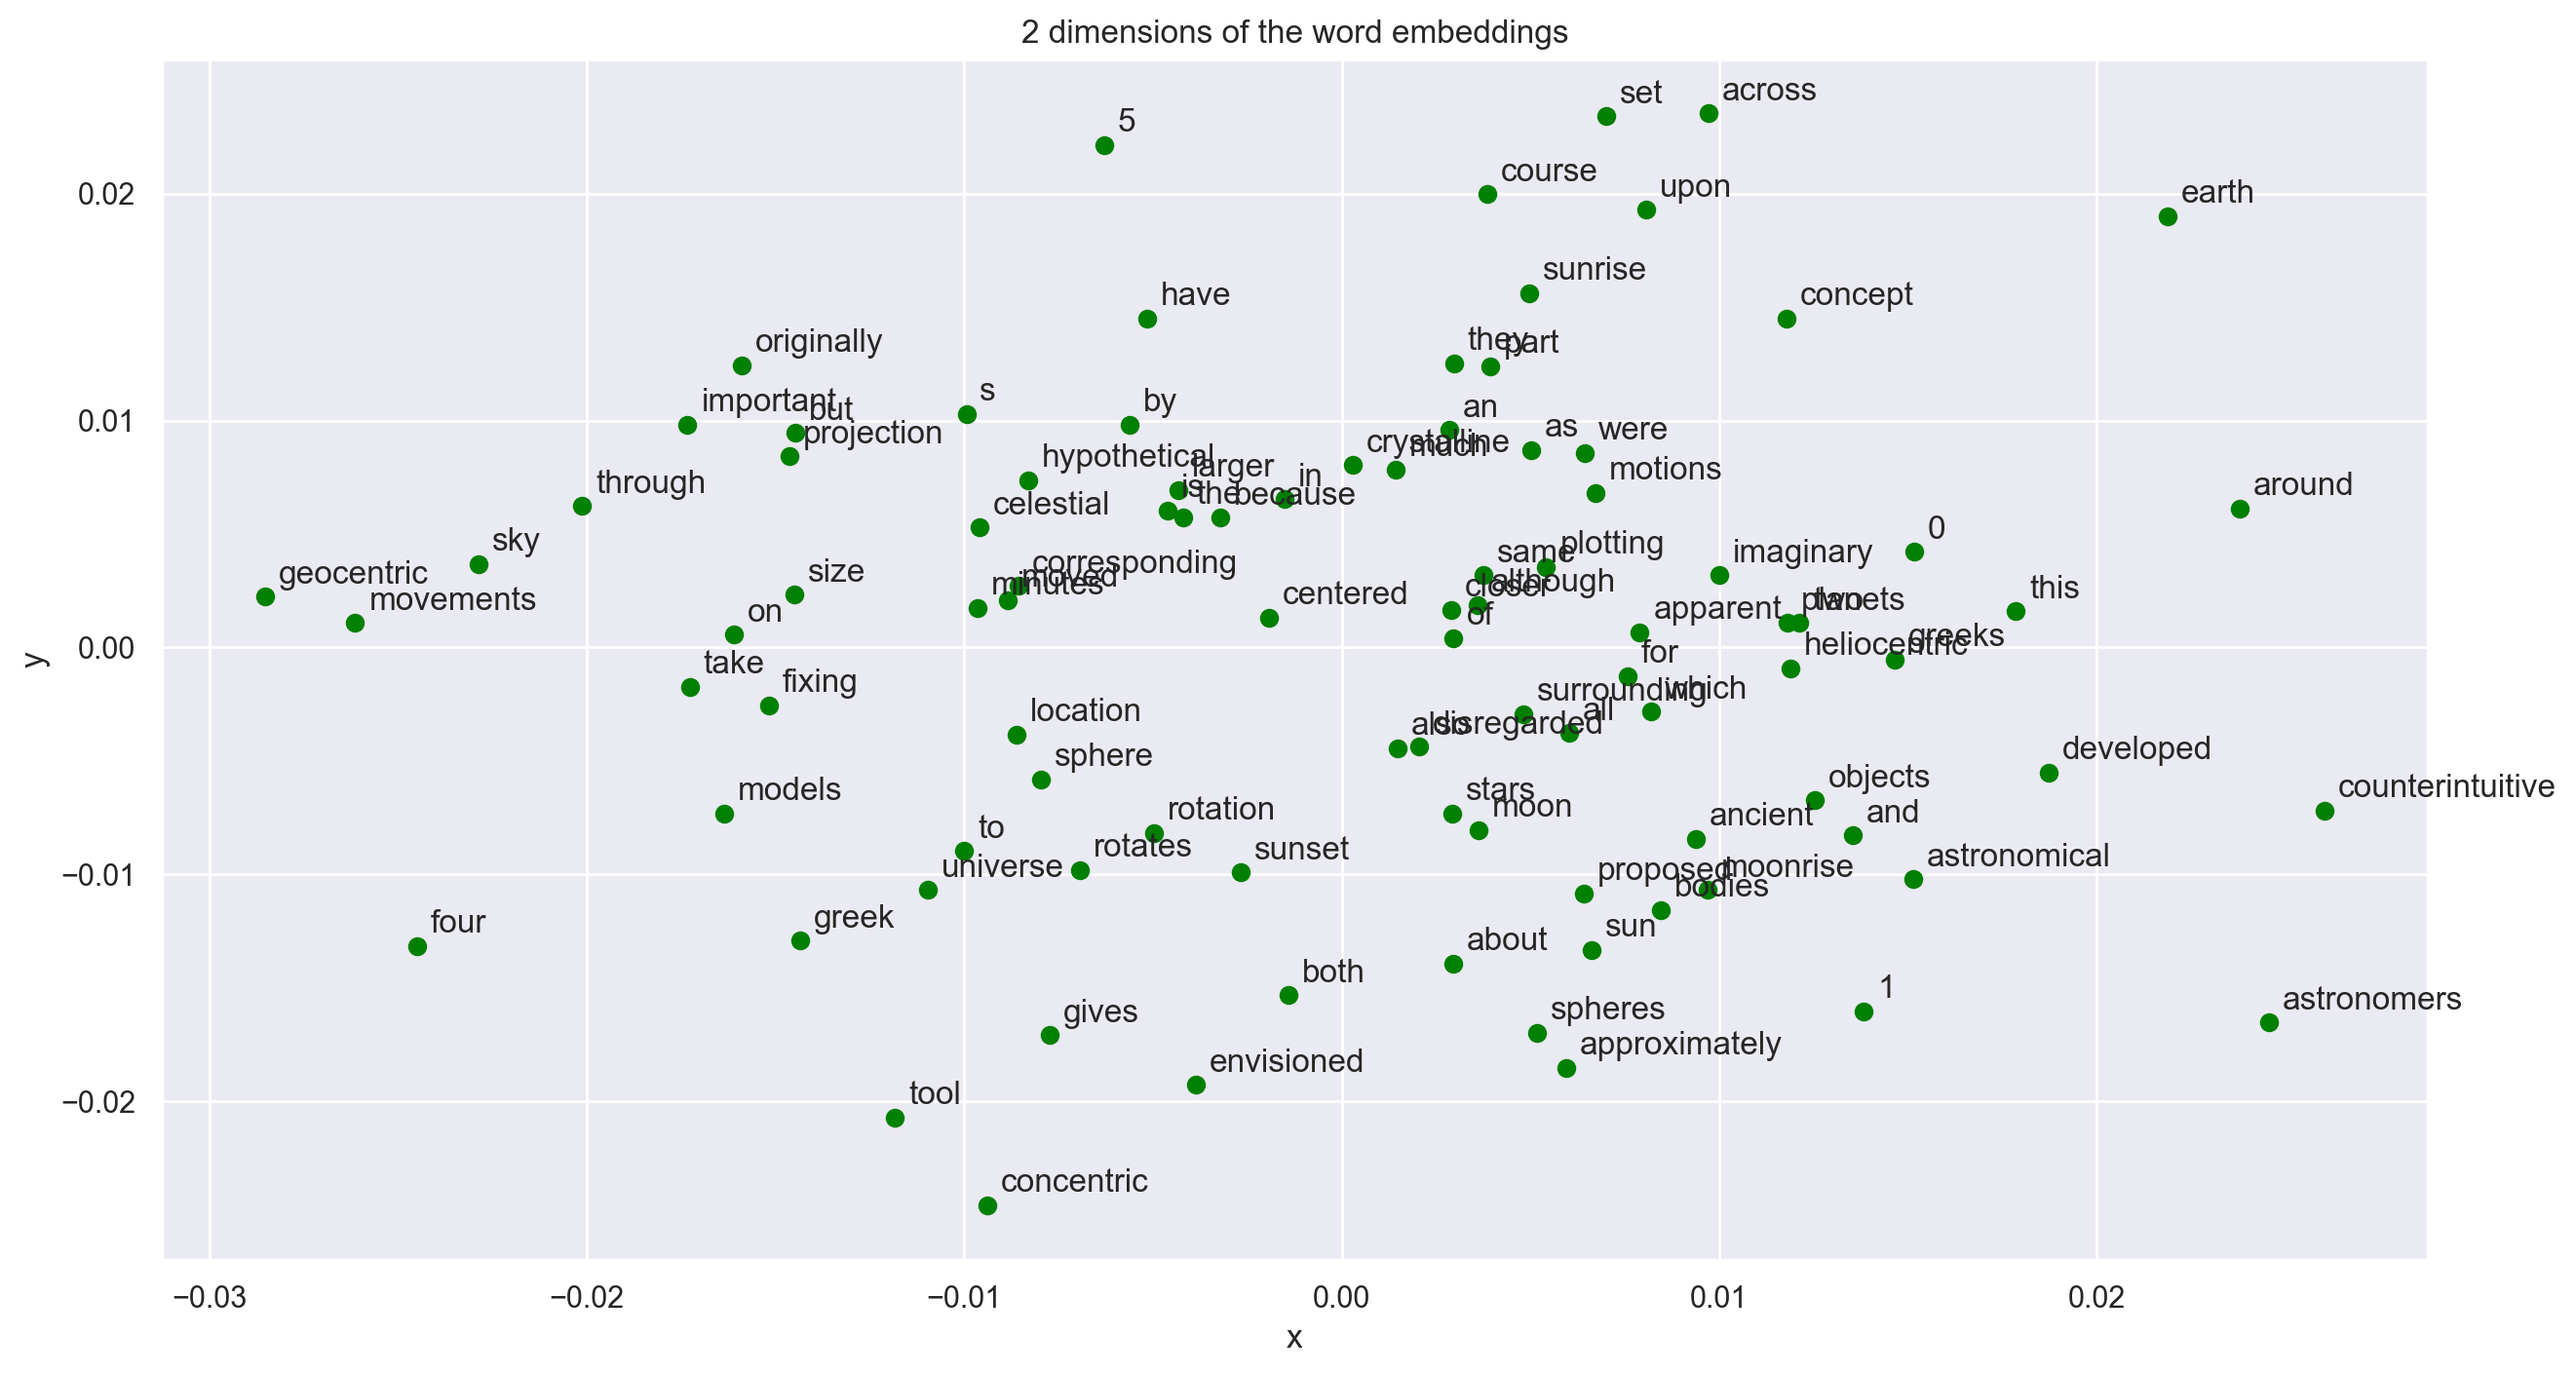

In [143]:
# Initialize the parameters and visualize the distribution (normal, random)
parameters = initialize_parameters(len(vocab), 5)
plot_embedding(parameters["EMBS"], voc2idx.values(), vocab)

Cost after epoch    0: 36.3463
Cost after epoch  200: 34.2531
Cost after epoch  400: 29.7637
Cost after epoch  600: 27.7114
Cost after epoch  800: 26.9650
Cost after epoch 1000: 26.8518
Cost after epoch 1200: 26.9963
Cost after epoch 1400: 26.8251
Cost after epoch 1600: 26.7198
Cost after epoch 1800: 26.7244
Cost after epoch 2000: 26.7390
Cost after epoch 2200: 26.7915
Cost after epoch 2400: 26.7476
Cost after epoch 2600: 26.6118
Cost after epoch 2800: 26.5227
Cost after epoch 3000: 26.5415
Cost after epoch 3200: 26.6527
Cost after epoch 3400: 26.7186
Cost after epoch 3600: 26.6814
Cost after epoch 3800: 26.6019
Cost after epoch 4000: 26.5313
Cost after epoch 4200: 26.4920
Cost after epoch 4400: 26.4694
Cost after epoch 4600: 26.4767
Cost after epoch 4800: 26.4942
training time: 0:00:14.713874
🚧 TODO I've kept the embedding of epoch 4414 with cost 26.4684.


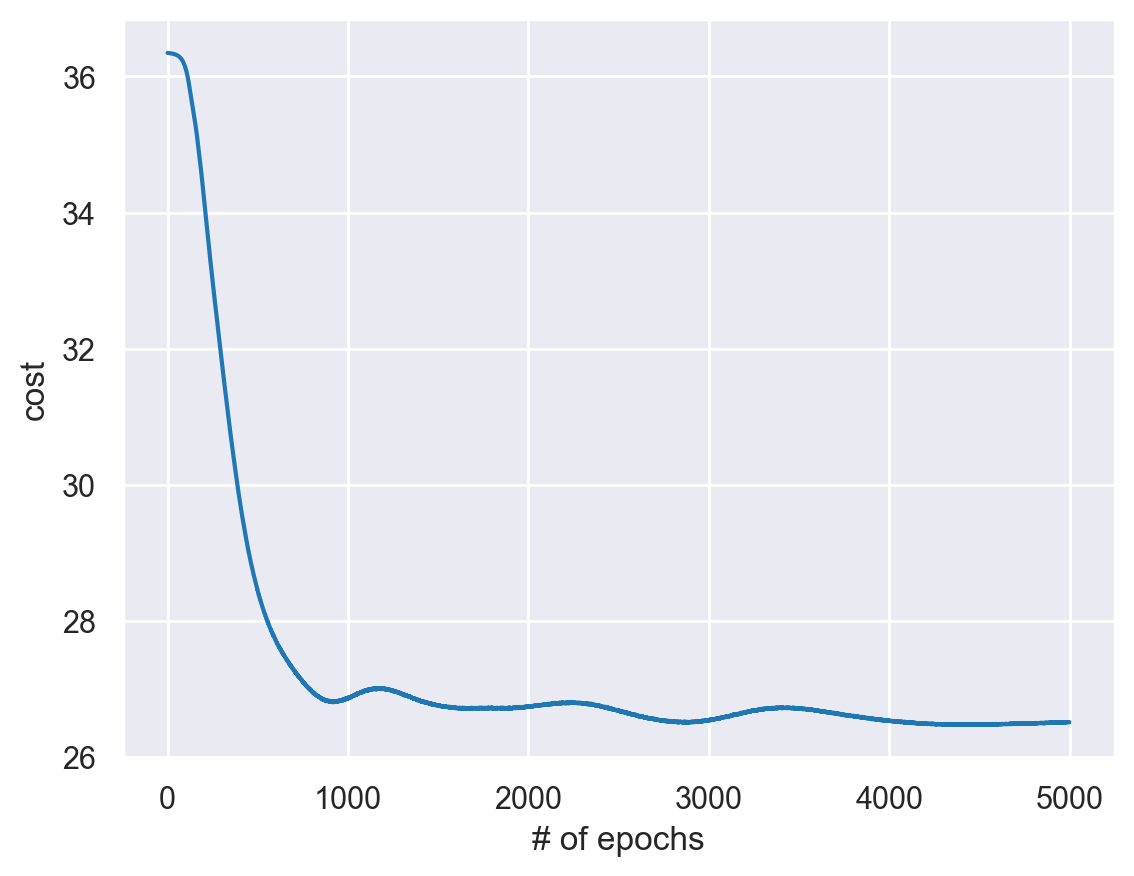

In [144]:
# Be patient:
parameters = skipgram_model_training(
    xs,
    ys,
    vocab_size,
    emb_size=50,
    learning_rate=0.05,
    epochs=5000,
    batch_size=128,
    parameters=None,
    print_cost=True,
)

In [145]:
# 🚧 TODO: as before find the predicted words from the context
test_xs = np.arange(vocab_size)
test_xs = np.expand_dims(test_xs, axis=0)
softmax_test, _ = forward_propagation(test_xs, parameters)
top_sorted_inds = np.argsort(softmax_test, axis=0)[-5:, :]
for input_ind in range(10):
    input_word = vocab[input_ind]
    print(f"{input_word}'s neighbor words: {output_words}")

the's neighbor words: ['semantic', 'between', 'relationships', 'dense', 'which']
of's neighbor words: ['semantic', 'between', 'relationships', 'dense', 'which']
celestial's neighbor words: ['semantic', 'between', 'relationships', 'dense', 'which']
sphere's neighbor words: ['semantic', 'between', 'relationships', 'dense', 'which']
sun's neighbor words: ['semantic', 'between', 'relationships', 'dense', 'which']
moon's neighbor words: ['semantic', 'between', 'relationships', 'dense', 'which']
and's neighbor words: ['semantic', 'between', 'relationships', 'dense', 'which']
an's neighbor words: ['semantic', 'between', 'relationships', 'dense', 'which']
earth's neighbor words: ['semantic', 'between', 'relationships', 'dense', 'which']
is's neighbor words: ['semantic', 'between', 'relationships', 'dense', 'which']


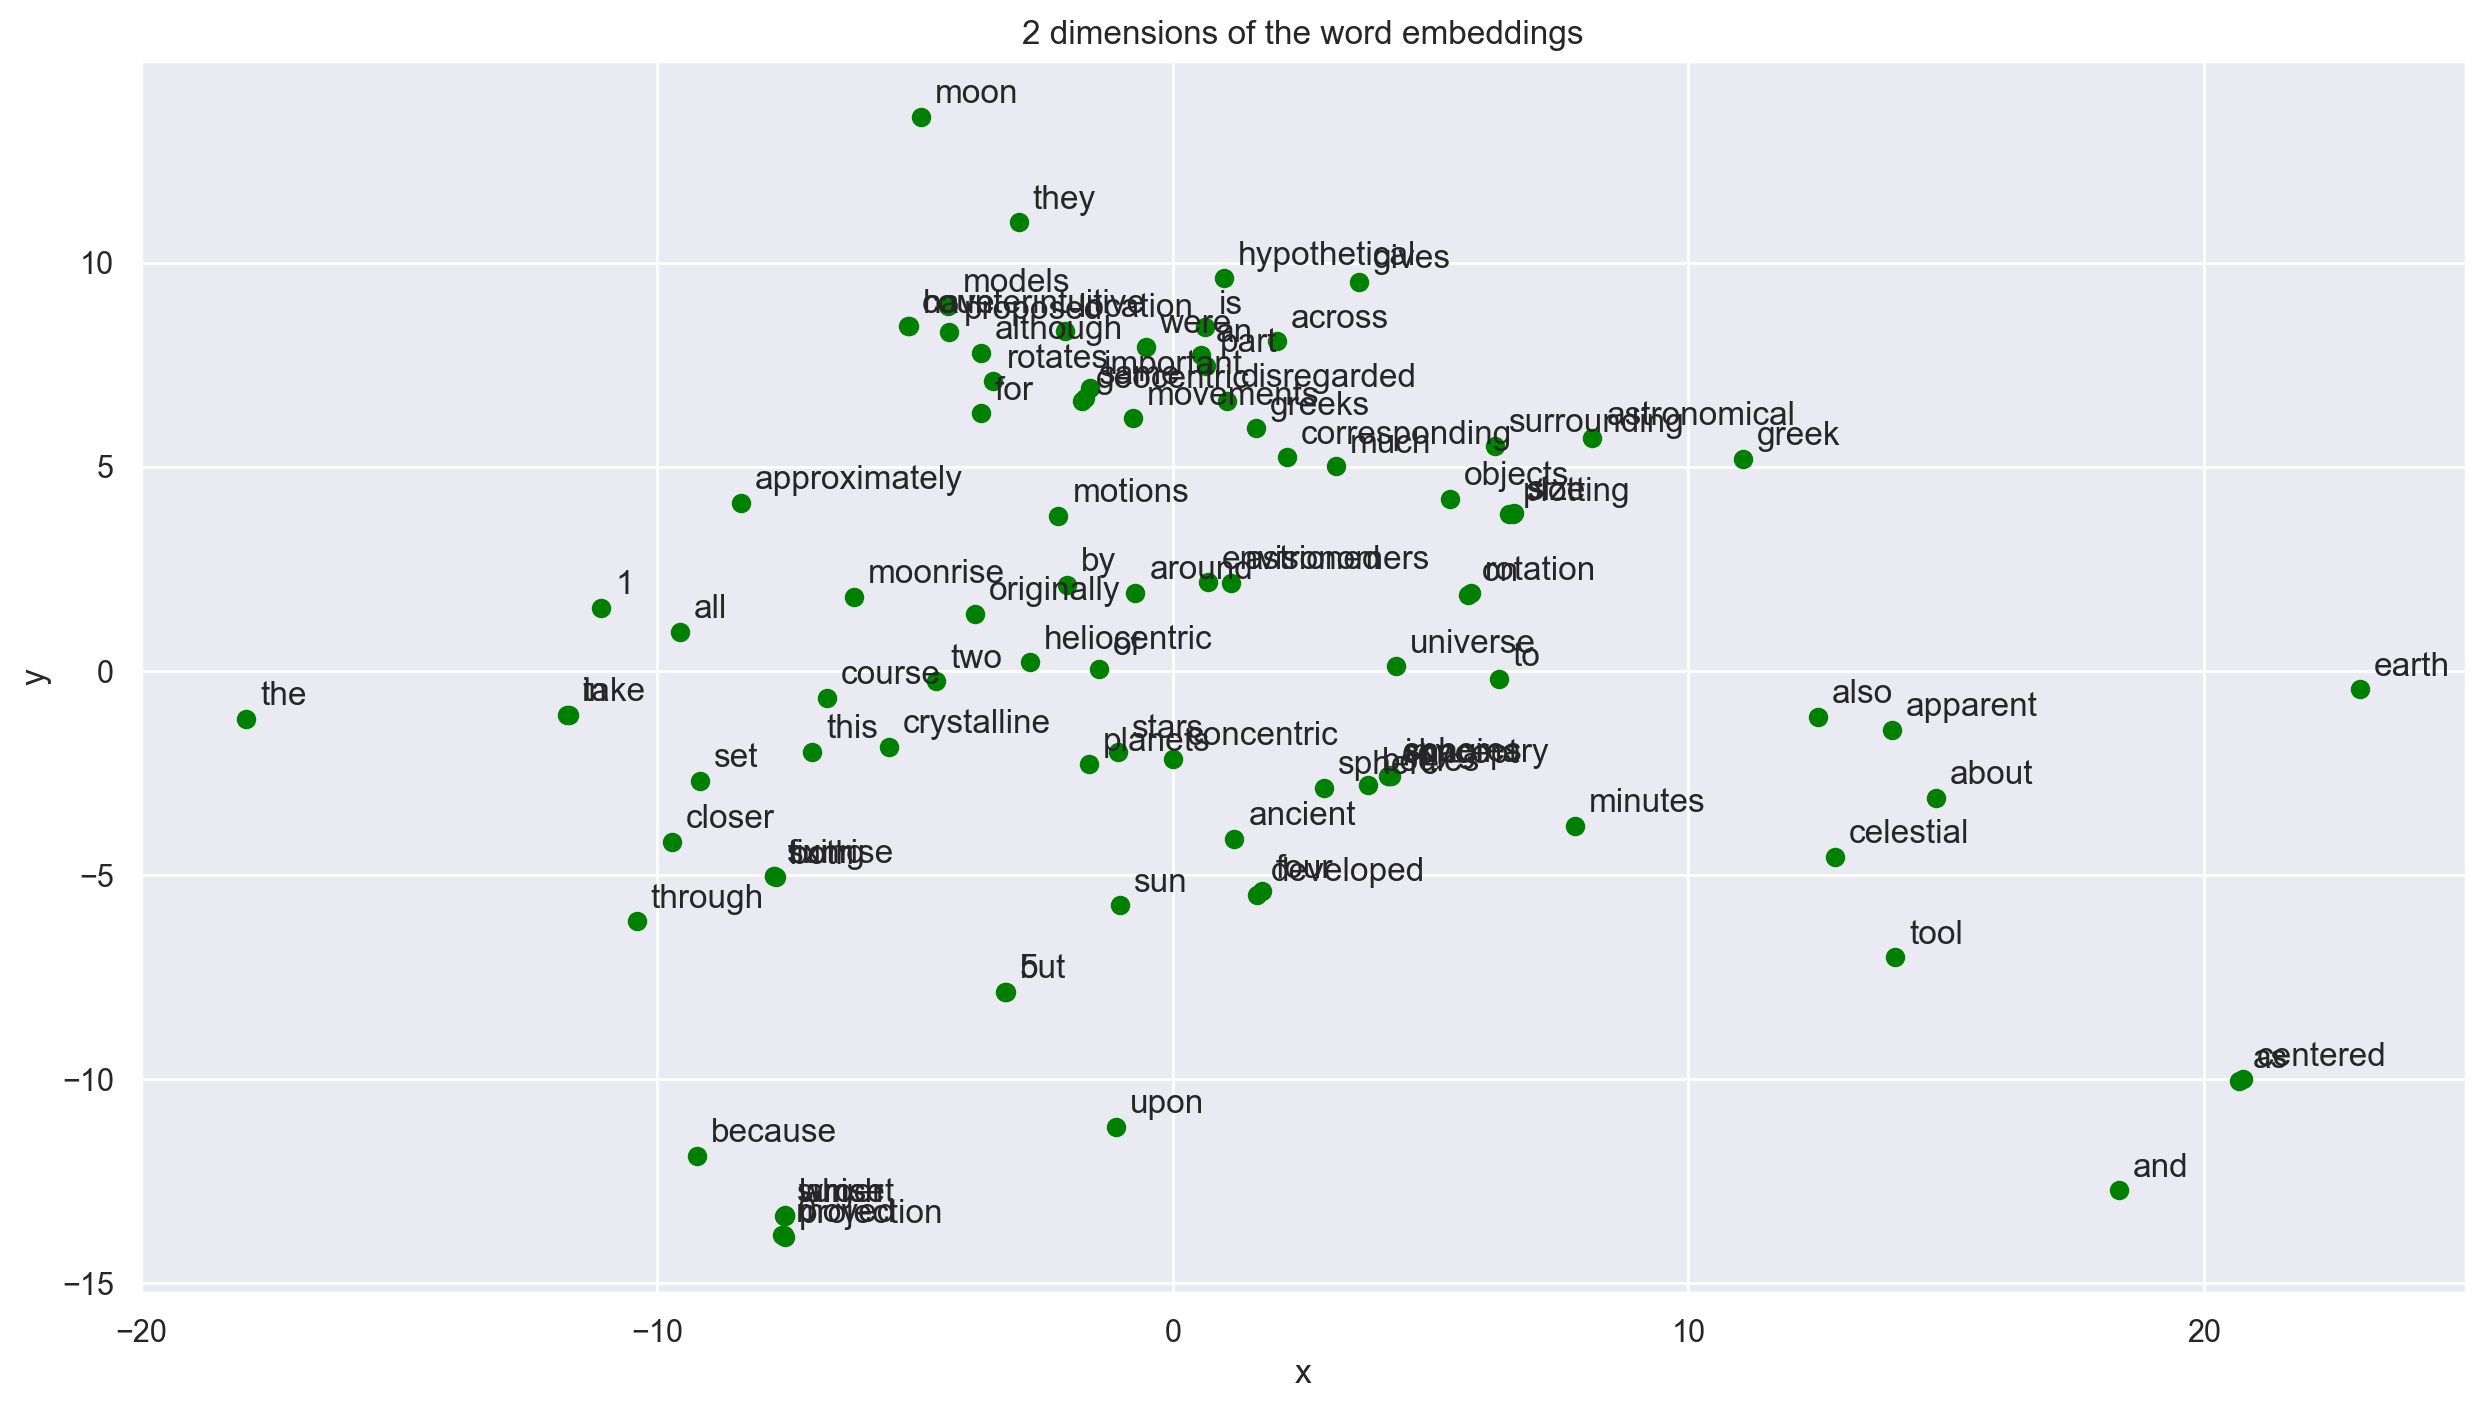

In [146]:
plot_embedding(parameters["EMBS"], voc2idx.values(), vocab)

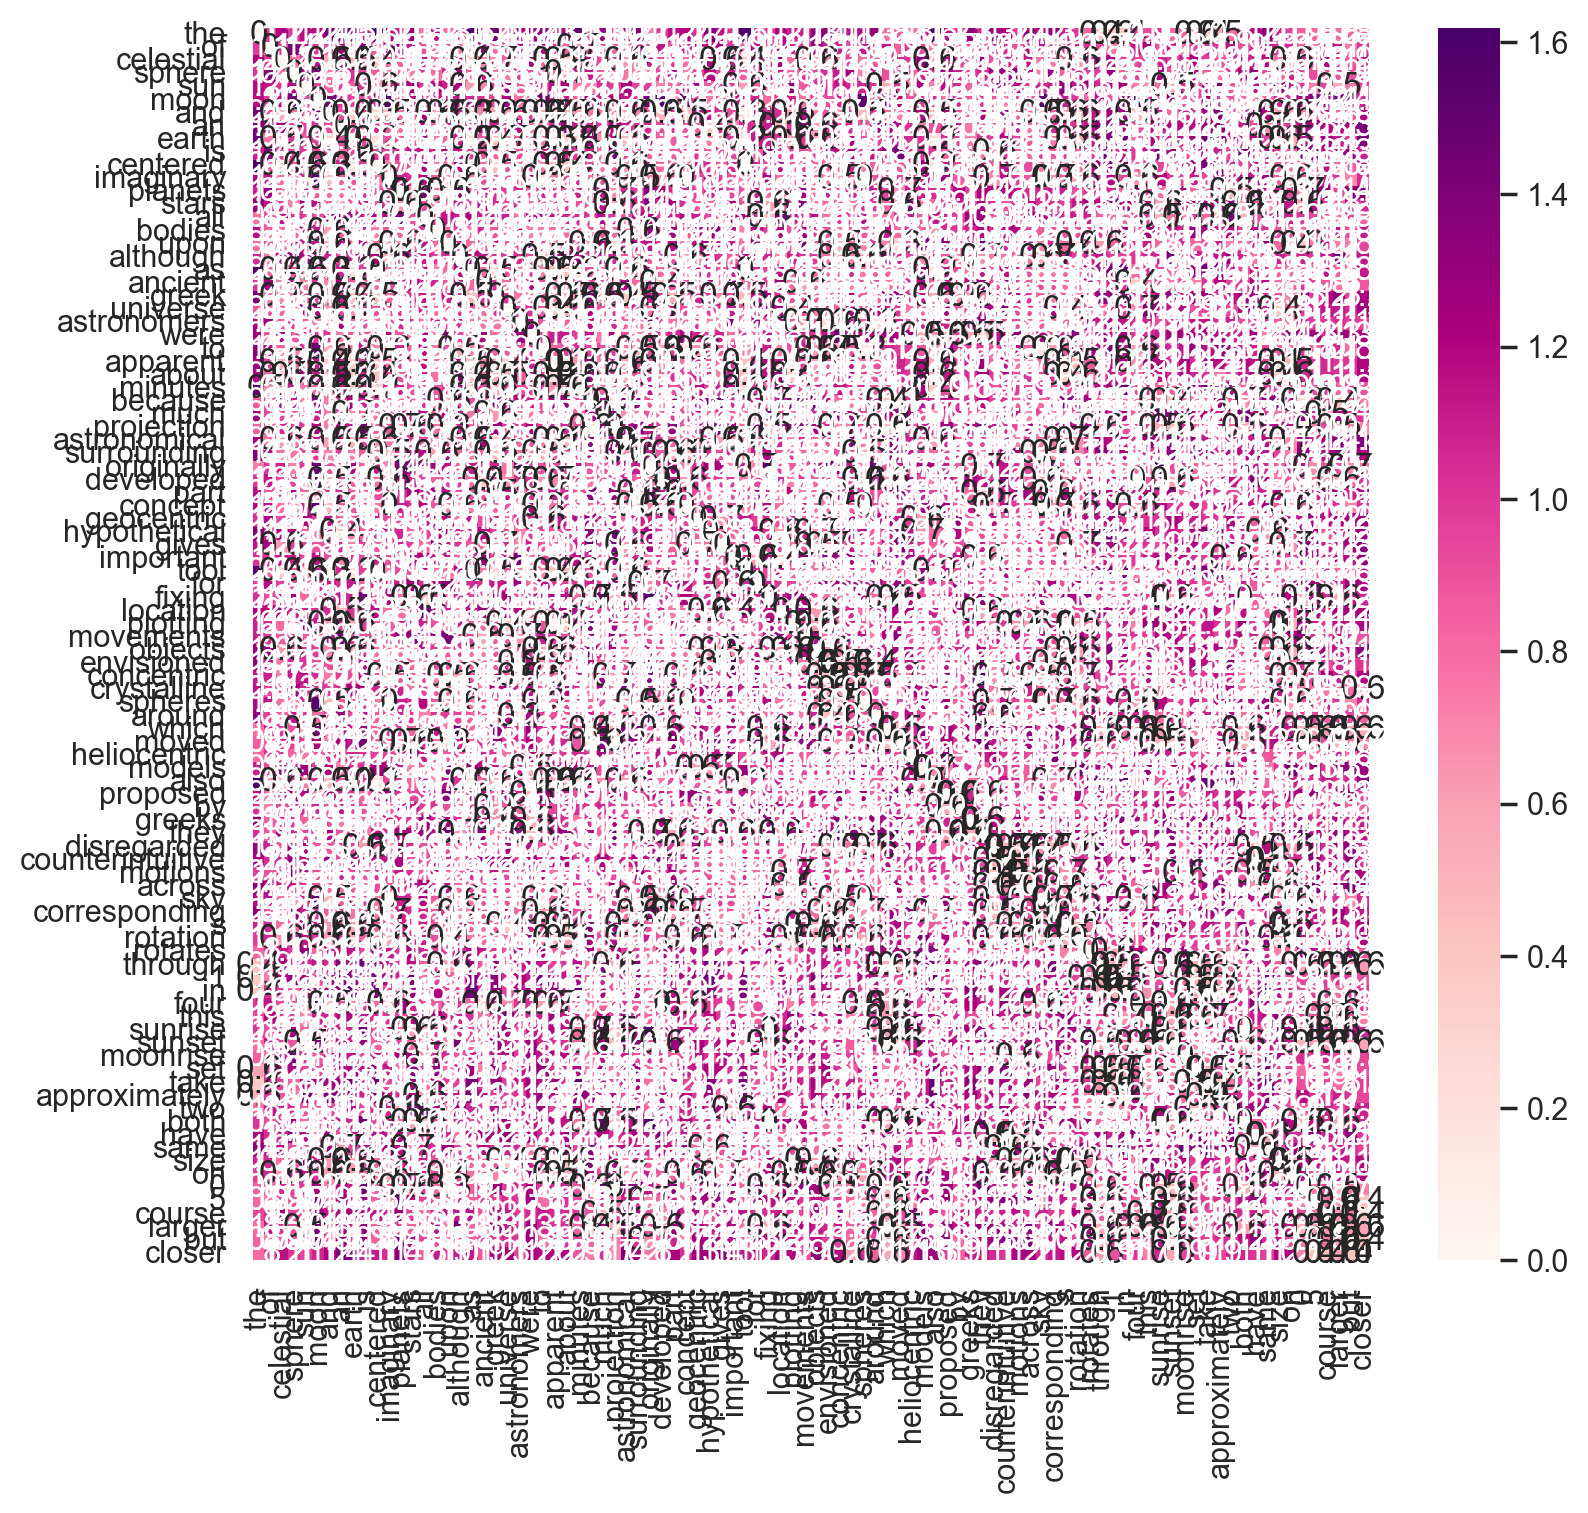

In [147]:
# very (!) slow and not very telling as it is.
# optional TODO : who can reduce the heatmap to a few frequent words?

cos_dists = scipy.spatial.distance.cdist(
    parameters["best_embeddings"], parameters["best_embeddings"], "cosine"
)
costs_heatmap(cos_dists, vocab)

### Conclusions:

- It works, but we would like to train on a much larger corpus

  - For that, we should:
  
    - Not exceed the lines when computing the neighborhood
  
    - Use negative sampling
  
    - Maybe implement a part in C and optimized for graphic card --
      or use a deep learning module (PyTorch, TensorFlow...)

- We will rely on an already implemented module: **Gensim**

→ Next section

____________

### 🌸 Gensim Word Embedding

- Word embedding

  - 🚧 TODO: complete a function to read a pre-computed embedding

  - 🚧 TODO: normalize vectors

  - 🚧 TODO: complete the function that finds the closest words by cosine distance

  - 🚧 TODO: test the nearest words

  - 🚧 mini-TODO: complete and test the function that computes analogies to see if our plotting is biased

- Later: text classification

  - 🚧 TODO: find and remove an outlier in our texts (to understand that the method works very well if the texts are very different)

  - Optional TODO: other methods than k-nearest neighbors

  - Optional TODO: redo based on keywords only

All TODOs are marked with the symbol 🚧

#### Load the pre-calculated word2vec
  
  - Get `enwiki-50k_100d.txt` from [here](https://gitlab.inria.fr/flandes/data-for-teaching/-/blob/master/enwiki-50k_100d.txt) and put it next to your notebook

  - It consists in a reduction to the 50k most frequent types of the full word2vec [pretrainded](https://wikipedia2vec.github.io/wikipedia2vec/pretrained/) on the complete English Wikipedia.  
  
    In particular this [file](http://wikipedia2vec.s3.amazonaws.com/models/en/2018-04-20/enwiki_20180420_100d.txt.bz2)
  
  - Open the file and explore the format
  
  - 🚧 Write a `read_vectors` function that gives a numpy matrix `embeddings` with one row per type (~ one word), each row represents the word. `embeddings[i, :]` corresponds to one type.

In [148]:
!wget https://gitlab.inria.fr/flandes/data-for-teaching/-/raw/master/enwiki-50k_100d.txt?inline=false

!mv enwiki-50k_100d.txt?inline=false enwiki-50k_100d.txt

--2025-02-08 17:23:40--  https://gitlab.inria.fr/flandes/data-for-teaching/-/raw/master/enwiki-50k_100d.txt?inline=false
Resolving gitlab.inria.fr (gitlab.inria.fr)... 128.93.193.23
Connecting to gitlab.inria.fr (gitlab.inria.fr)|128.93.193.23|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37929526 (36M) [application/octet-stream]
Saving to: ‘enwiki-50k_100d.txt?inline=false’

enwiki-50k_100d.txt 100%[===================>]  36.17M   122MB/s    in 0.3s    

2025-02-08 17:23:41 (122 MB/s) - ‘enwiki-50k_100d.txt?inline=false’ saved [37929526/37929526]



In [149]:
def read_vectors(vocab_size=50000, dimension=100):
    """
    function that reads a backup of an embedding
    returns
    - a word dictionary type -> index
    - the inverse dictionary
    - a matrix containing a vector of words per word type
    check the file to understand the format
    """
    embeddings = np.zeros((vocab_size, dimension))
    w2i, i2w = {}, {}  # as before
    i = 0
    with open("enwiki-50k_100d.txt") as f:
      for line in f.readlines():
        # 🚧 TODO:
        # ...
        if i >= vocab_size:
                break
            
        splitted = line.strip().split()
        word = splitted[0]
        vector = splitted[1:]
        
        # Populate dictionaries
        w2i[word] = i
        i2w[i] = word
        
        # Populate the embeddings matrix
        embeddings[i] = np.array(vector, dtype=np.float32)
        
        i += 1

        # end TODO
    assert len(w2i) == len(i2w) == len(embeddings)
    return w2i, i2w, embeddings

In [150]:
w2i, i2w, embeddings = read_vectors()

print(len(w2i), len(i2w), embeddings.shape)

50000 50000 (50000, 100)


### Objectives

We want to make a python function that for a given word returns the K nearest (semantic) neighbors

To do this, we need to

1. calculate the cosine distance between them

2. order the distances by decreasing orders


#### 1. Calculating the cosine distance
**Hint**, we can do this in two substeps:
- 🚧 normalize the embeddings (with respect to the rows, i.e., each word vector to a unit norm)
- 🚧 calculate scalar product between the source word embedding with the whole embedding space

In [151]:
# 🚧 TODO: normalize the embeddings (with respect to the lines,
#     i.e. each word vector to a unit norm)

normed_embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)

**⚠ Achtung!!!**:

- To simplify the calculations later, we will base our calculations on the `normed_embeddings` matrix. Thus, we won't need to divide the dot product of the two vectors by their norms (the cosine similarity of two unit vectors is just the dot product of the vectors).

- If you want to perform a similarity calculation based on another measure (Euclidean distance?), then you will have to base your calculations on the raw `embeddings` matrix (which is not normalized!)

In [152]:
def find_closest_words_from_vector(vector, k_max=10):
    """For a given vector, find the K nearest semantic neighbors"""
    closest_words = []

    cosine_similarities = np.dot(normed_embeddings, vector)
    # cosine_similarities = # 🚧 TODO: ...?? think of the scalar product

    sorted_indexes = np.argsort(cosine_similarities)
    # sorted_indexes =    # 🚧 TODO: ...?? matrix sorted from smallest to largest

    # Only K largest is of interest to us
    for k in range(1, k_max + 1):
        neighbor_index = sorted_indexes[-k]
        # Append (word, similarity)
        closest_words.append(
            (i2w[neighbor_index], cosine_similarities[neighbor_index])
        )

    return closest_words

In [153]:
def find_closest_words_from_word(word, k_max=10):
    """For a given word 'word', find the K nearest semantic neighbors"""
    word_index = w2i[word]
    word_vector = normed_embeddings[word_index]
    closest_words = find_closest_words_from_vector(word_vector, k_max)
    return closest_words

In [154]:
def pretty_show(closest_words):
    """prettify the print for the closest words"""
    for word, similarity in closest_words:
        print(word.ljust(15, " "), similarity.round(3))
    print("___\n")

In [155]:
# Creative time! Let's test our function on some terms
pretty_show(find_closest_words_from_word("french"))
pretty_show(find_closest_words_from_word("what"))
# trained on Wikipédia. --> few swear words... (e.g., holy ...)
pretty_show(find_closest_words_from_word("holy"))
pretty_show(find_closest_words_from_word("cool"))

french          1.0
françois        0.733
belgian         0.729
haitian         0.723
leclerc         0.711
spanish         0.709
étienne         0.706
algerian        0.704
france          0.698
pierre          0.69
___

what            1.0
why             0.83
really          0.829
whatever        0.816
something       0.81
everything      0.807
nothing         0.806
definitely      0.804
how             0.799
actually        0.788
___

holy            1.0
blessed         0.735
redeemer        0.725
sacrament       0.724
sacred          0.721
rosary          0.72
sepulchre       0.72
baptism         0.685
saviour         0.676
eucharist       0.671
___

cool            1.0
warm            0.836
chilly          0.771
hot             0.746
sunny           0.741
cooler          0.734
cold            0.733
winters         0.733
wet             0.727
summers         0.724
___



### Analogies

Finally the pretty analogies in the embeddings!

In [156]:
def find_analogies(wpos1, wpos2, wneg):
    """
    wpos1: the first positive word
    wpos2: the 2nd positive word
    wneg: the negative word
    Find the analog "analog" such that
        <"analog" is to "wpos2" what "wneg" is to "wpos1">
    For example: <"queen" is to "woman" what "king" is to "man">
    """
    # add the positive vectors, substract the negative vector:
    vector_analog  = normed_embeddings[w2i[wpos2]] - normed_embeddings[w2i[wpos1]] + normed_embeddings[w2i[wneg]]
    return find_closest_words_from_vector(vector_analog)

In [157]:
pretty_show(find_analogies("king", "woman", "man"))
pretty_show(find_analogies("nurse", "man", "woman"))  # Watch out for bias!
# 🚧 TODO: Find other "questionable" examples

woman           1.435
man             1.329
girl            1.169
person          1.073
schoolgirl      1.02
blonde          1.003
housewife       0.997
haired          0.992
thing           0.985
loner           0.978
___

man             1.379
woman           1.161
thing           0.962
person          0.957
ape             0.952
dreamer         0.911
girl            0.909
stranger        0.904
wonder          0.903
jew             0.894
___



# 💥 Text classification by embeddings

In [158]:
def doc2vec(text):
    """
    The function takes a text, cuts it into tokens
    For each token, if the token is in w2i, we take its vector
    We add the vectors and renormalize
    Returns: vector of the same format as the ones we have for each word
    """
    tokens = re.findall(r"\w+", text)
    vectors = [normed_embeddings[w2i[t]] for t in tokens if t in w2i]
    somme = sum(vectors)
    normalised = somme / np.sqrt(np.sum(somme ** 2))
    return normalised

In [159]:
vex = doc2vec("let's see how this works, this word2vec thing!")
vex

array([ 0.07387233,  0.12554409, -0.03471597,  0.12111489, -0.05750588,
       -0.06976969,  0.11069114, -0.00413172, -0.03993599, -0.11440254,
       -0.02002396, -0.06674013,  0.05186859,  0.02370464,  0.14302237,
       -0.17568769, -0.08483406, -0.11740287,  0.02232566,  0.0244962 ,
       -0.02370285, -0.04889281, -0.09490498,  0.1441267 , -0.14840299,
       -0.06995096,  0.01508538, -0.13237274,  0.08919033,  0.23805662,
        0.15732137,  0.04487463,  0.06990924,  0.10595372, -0.04686351,
        0.04037394,  0.01301547,  0.00769076,  0.03119486, -0.04906946,
       -0.01264446,  0.11649464, -0.08002043,  0.05053645, -0.15290941,
       -0.0446294 , -0.09043782,  0.16251262, -0.16145541,  0.11196586,
       -0.07868526,  0.11920033, -0.05469899,  0.03121956,  0.04826111,
       -0.0215742 , -0.08538961,  0.00766826, -0.0369743 ,  0.070069  ,
       -0.14247876, -0.10275707, -0.06764206,  0.13842822,  0.22479675,
       -0.1171155 , -0.15569672, -0.01623687, -0.02873219, -0.18

---